## Importing required libraries

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.nn.init as nninit
import torch.onnx

In [2]:
print(torch.__version__)

1.4.0


## Creating pixels with a neural net


In [3]:
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.ln1 = nn.Linear(z_size + 3,32,bias=False)  # set the input size according to z_size
        self.ln2 = nn.Linear(32,32,bias=False)
        self.ln3 = nn.Linear(32,32,bias=False)
        self.ln4 = nn.Linear(32,3,bias=False)           # output size is 3 for RGB images
        nninit.uniform_(self.ln1.weight, a=-1,b=1)
        nninit.uniform_(self.ln2.weight,a=-1,b=1)
        nninit.uniform_(self.ln3.weight,a=-1,b=1)
        nninit.uniform_(self.ln4.weight,a=-1,b=1)
        self.tanh1 = nn.Tanh()
        self.tanh2 = nn.Tanh()
        self.tanh3 = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        U = self.ln1(x)
        U = self.tanh1(U)
        U = self.ln2(U)
        U = self.tanh2(U)
        U = self.ln3(U)
        U = self.tanh3(U)
        U = self.ln4(U)
        return self.sigmoid(U)

## Define variables for the image creation ##

In [4]:
height = 200
width = 200
scale = 0.3
z_size = 7  
num_images = 2
alpha = 1  # constant for shifting vector z

model_dir = 'models/'
base_name = "images/"
model_name = 'arts_model'
pytorch_ending = ".pt"
onnx_ending = ".onnx"

## Helper functions

In [5]:
def createInputVec(z,x,y):
    '''
    Create the input vector for the neural net
    '''
    
    r = math.sqrt(((x*scale-(x*scale/2))**2) + ((y*scale-(y*scale/2))**2) )
    z_size = len(z)
    input = torch.rand(1,z_size + 3)
    
    for i in range(z_size):
        input[0][i] = z[i] * scale
        
    input[0][z_size] = x * scale
    input[0][z_size+1] = y * scale
    input[0][z_size+2] = r
    input = Variable(input)
    return input

In [6]:
def update_z(z, alpha=1):
    '''
    shifts the vector z by alpha
    '''
    
    for i in range (len(z)):
        z[i] = z[i] + alpha
    return z

## Run the image creation process

Please wait while creating image no. 1
images/arts_model_1.png


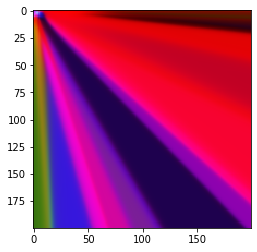

Please wait while creating image no. 2
images/arts_model_2.png


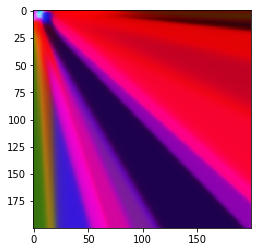

In [7]:
G = net()
z = torch.rand(z_size)

#batch produce images
for i in range(num_images):
    print("Please wait while creating image no. "+str(i+1))

    update_z(z, alpha)
     
    image = np.zeros((height * width, 3)) 
    for h in range(height):
        
        for w in range(width):
            input = createInputVec(z,h,w)
            image[h * width + w] = G(input).data.numpy()

    image = image.reshape(height, width,3) 
    image_name = base_name + model_name + "_" + str(i+1)+ ".png"
    print(image_name)

    imgplot = plt.imshow(image)
    plt.show()
    plt.imsave(image_name, image)


## Save pytorch and ONNX models ##
The ONNX model will be needed to create the IR (intermediate represenation) model for the openVINO toolkit.

In [8]:
# save pytorch model
torch.save(G, model_dir + model_name + pytorch_ending)

# save onnx model
dummy_input = torch.randn(1, z_size + 3) # same size as input.shape
torch.onnx.export(G, dummy_input, model_dir + model_name + onnx_ending)
torch.onnx.export(G, dummy_input, model_dir + model_name + "_40000"+ onnx_ending)  # create a second model for batch inference

C:\Users\susbr\AppData\Local\Continuum\anaconda3\envs\pytorch14\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Converting the model to Intermediate Represenetation (IR)
Go to ```<INSTALL_DIR>/deployment_tools/model_optimizer``` directory and run the mo.py file.<br/>
```python3 mo.py --input_model <path to model>.onnx```


### Windows version:
Please update the path according to your installation of openVINO

In [9]:
%run "C:\Program Files (x86)\IntelSWTools\openvino\deployment_tools\model_optimizer\mo.py" --input_model models/arts_model.onnx -o models/

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	G:\Intel-AI\Artsificial\SPAIC Artsificial\models/arts_model.onnx
	- Path for generated IR: 	G:\Intel-AI\Artsificial\SPAIC Artsificial\models/
	- IR output name: 	arts_model
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
ONNX specific parameters:
Model Optimizer version: 	2020.1.0-61-gd349c3ba4a

[ SUCCESS ] Generated IR version 10 model.
[ SUCCESS ] XML file: G:\Intel-AI\Artsificial\SPAIC Artsificial\models/arts_model.xml
[ SUCCESS ] BIN file: G:\

### Creating IR model with batch size 40000
This model will be used in future notebooks that work with a faster generative approach

In [10]:
%run "C:\Program Files (x86)\IntelSWTools\openvino\deployment_tools\model_optimizer\mo.py" --input_model models/arts_model_40000.onnx -o models/ --batch 40000

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	G:\Intel-AI\Artsificial\SPAIC Artsificial\models/arts_model_40000.onnx
	- Path for generated IR: 	G:\Intel-AI\Artsificial\SPAIC Artsificial\models/
	- IR output name: 	arts_model_40000
	- Log level: 	ERROR
	- Batch: 	40000
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
ONNX specific parameters:
Model Optimizer version: 	2020.1.0-61-gd349c3ba4a

[ SUCCESS ] Generated IR version 10 model.
[ SUCCESS ] XML file: G:\Intel-AI\Artsificial\SPAIC Artsificial\models/arts_model_40000.xml
[ SUCCESS ] BIN file: G:\Intel-AI\Artsifi

### Linux version:

In [11]:
# TODO: Add linux conversion